## Imports + EDA

In [1]:
# Imports
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats
import warnings
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt

In [53]:
BASE_URL = "https://raw.githubusercontent.com/siddharthyashkukreja-cloud/QuantInvesting/35528ac1dde5d2d873e1adfd0864381326d3b768/"

# Load the data
dfPredictors = pd.read_csv(f"{BASE_URL}/predictor_data.csv")
dfPredictors.drop(columns=['Unnamed: 0'], axis=1, inplace=True) # Drop unnecessary column

variables_to_negate = ['ntis', 'tbl', 'lty', 'lagINFL']
for var in variables_to_negate:
    dfPredictors[var] = -dfPredictors[var]
dfPredictors.head()

,yyyyq,r,logDP,logDY,logEP,logDE,svar,b/m,ntis,tbl,lty,ltr,tms,dfy,dfr,lagINFL
0,19264,0.014359,-2.973012,-2.966318,-2.386837,-0.586175,0.003164,0.441476,-0.050876,-0.0307,-0.0354,0.034369,0.0047,0.0100,-0.013227,0.011299
1,19271,0.040386,-2.976535,-2.944439,-2.445079,-0.531456,0.001681,0.469765,-0.046357,-0.0320,-0.0331,0.042080,0.0011,0.0092,-0.021137,-0.011429
2,19272,0.045197,-3.007309,-2.948756,-2.531330,-0.475979,0.001819,0.452385,-0.058822,-0.0307,-0.0334,0.003423,0.0027,0.0097,0.005290,0.022599
3,19273,0.157540,-3.129097,-2.980280,-2.707759,-0.421338,0.002826,0.380586,-0.094613,-0.0268,-0.0330,0.014461,0.0062,0.0088,0.009170,-0.017341
4,19274,0.031700,-3.132667,-3.102780,-2.766942,-0.365725,0.003093,0.374689,-0.076471,-0.0317,-0.0316,0.027038,-0.0001,0.0086,-0.007817,0.017045


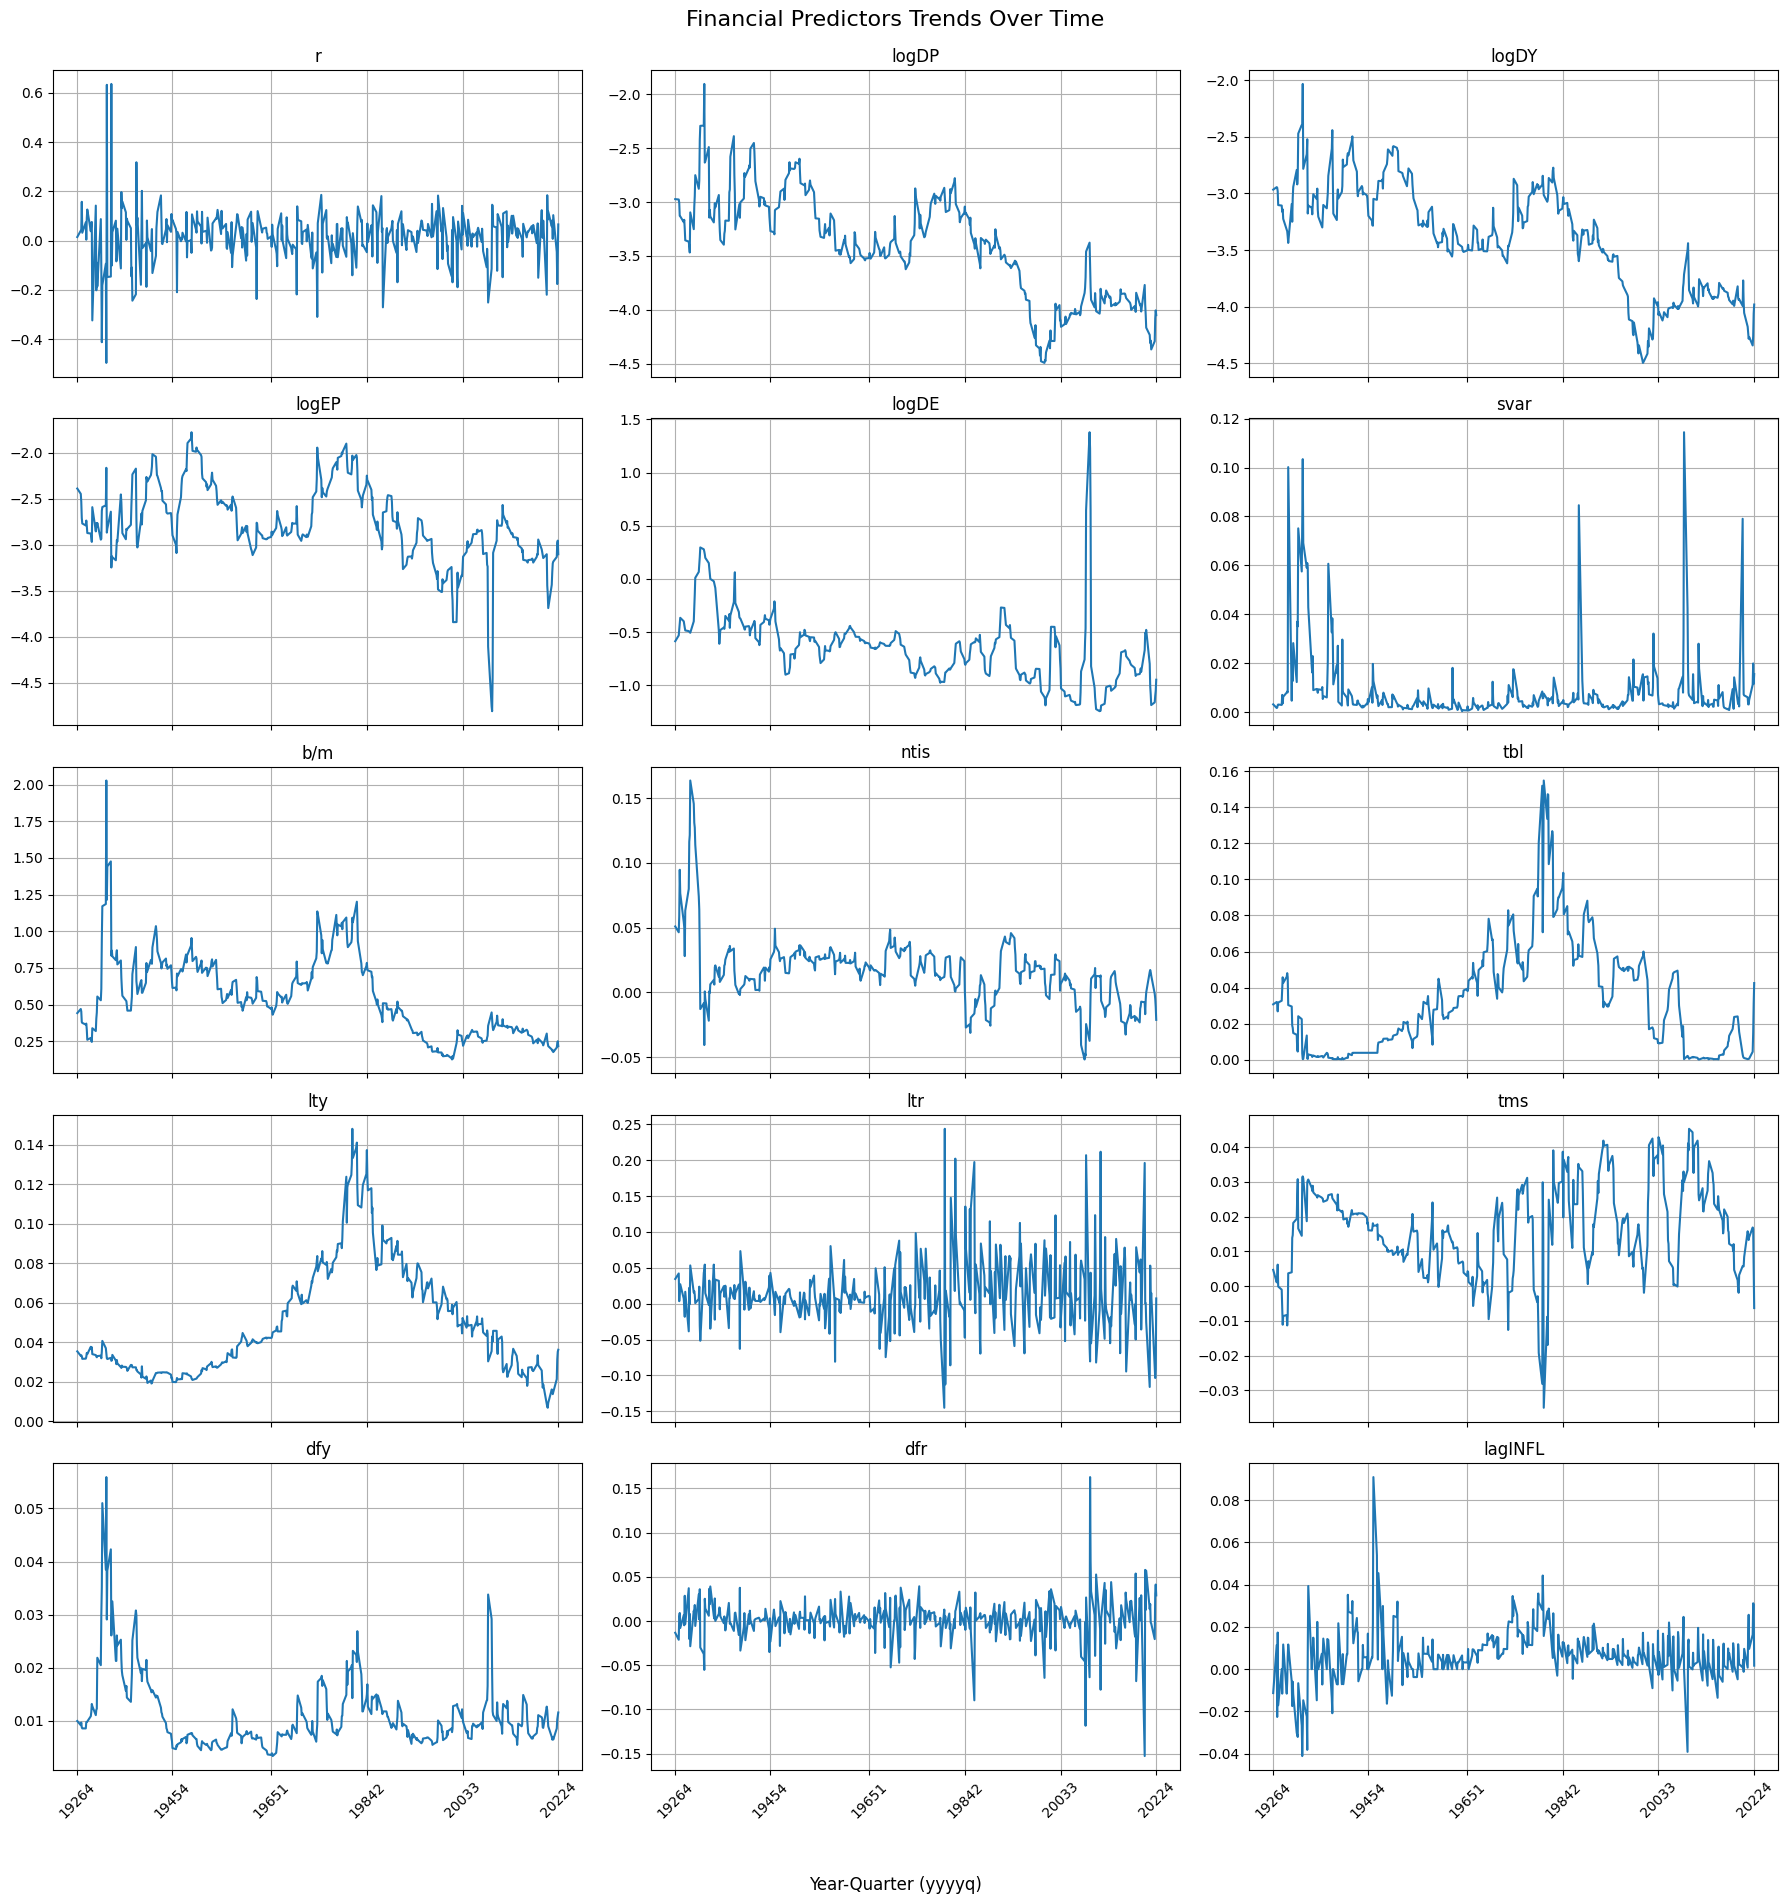

In [54]:

# Determine number of columns (excluding yyyyq which is our x-axis)
num_cols = len(dfPredictors.columns) - 1
num_rows = (num_cols + 2) // 3  # 3 plots per row, rounded up

# Create figure with subplots
fig, axes = plt.subplots(num_rows, 3, figsize=(18, num_rows * 4), sharex=True)
axes = axes.flatten()  # Flatten to make indexing easier

# Plot each column in its own subplot
col_idx = 0
for col in dfPredictors.columns:
    if col != 'yyyyq':  # Skip the x-axis column
        axes[col_idx].plot(dfPredictors_sorted['yyyyq'], dfPredictors_sorted[col])
        axes[col_idx].set_title(col)
        axes[col_idx].grid(True)
        col_idx += 1

# Hide any unused subplots
for i in range(col_idx, len(axes)):
    fig.delaxes(axes[i])

# Set major ticks at reasonable intervals for better readability
tick_indices = np.linspace(0, len(dfPredictors_sorted)-1, 6, dtype=int)
tick_values = dfPredictors_sorted.iloc[tick_indices]['yyyyq'].values

# Apply x-ticks to all subplots
for ax in axes[:col_idx]:
    ax.set_xticks(tick_values)
    ax.set_xticklabels(tick_values, rotation=45)

# Add overall title and x-axis label
plt.suptitle('Financial Predictors Trends Over Time', fontsize=16)
fig.text(0.5, 0.04, 'Year-Quarter (yyyyq)', ha='center', fontsize=12)

# Tight layout
plt.tight_layout()
plt.subplots_adjust(top=0.95, bottom=0.1)
plt.show()

Correlation Matrix:


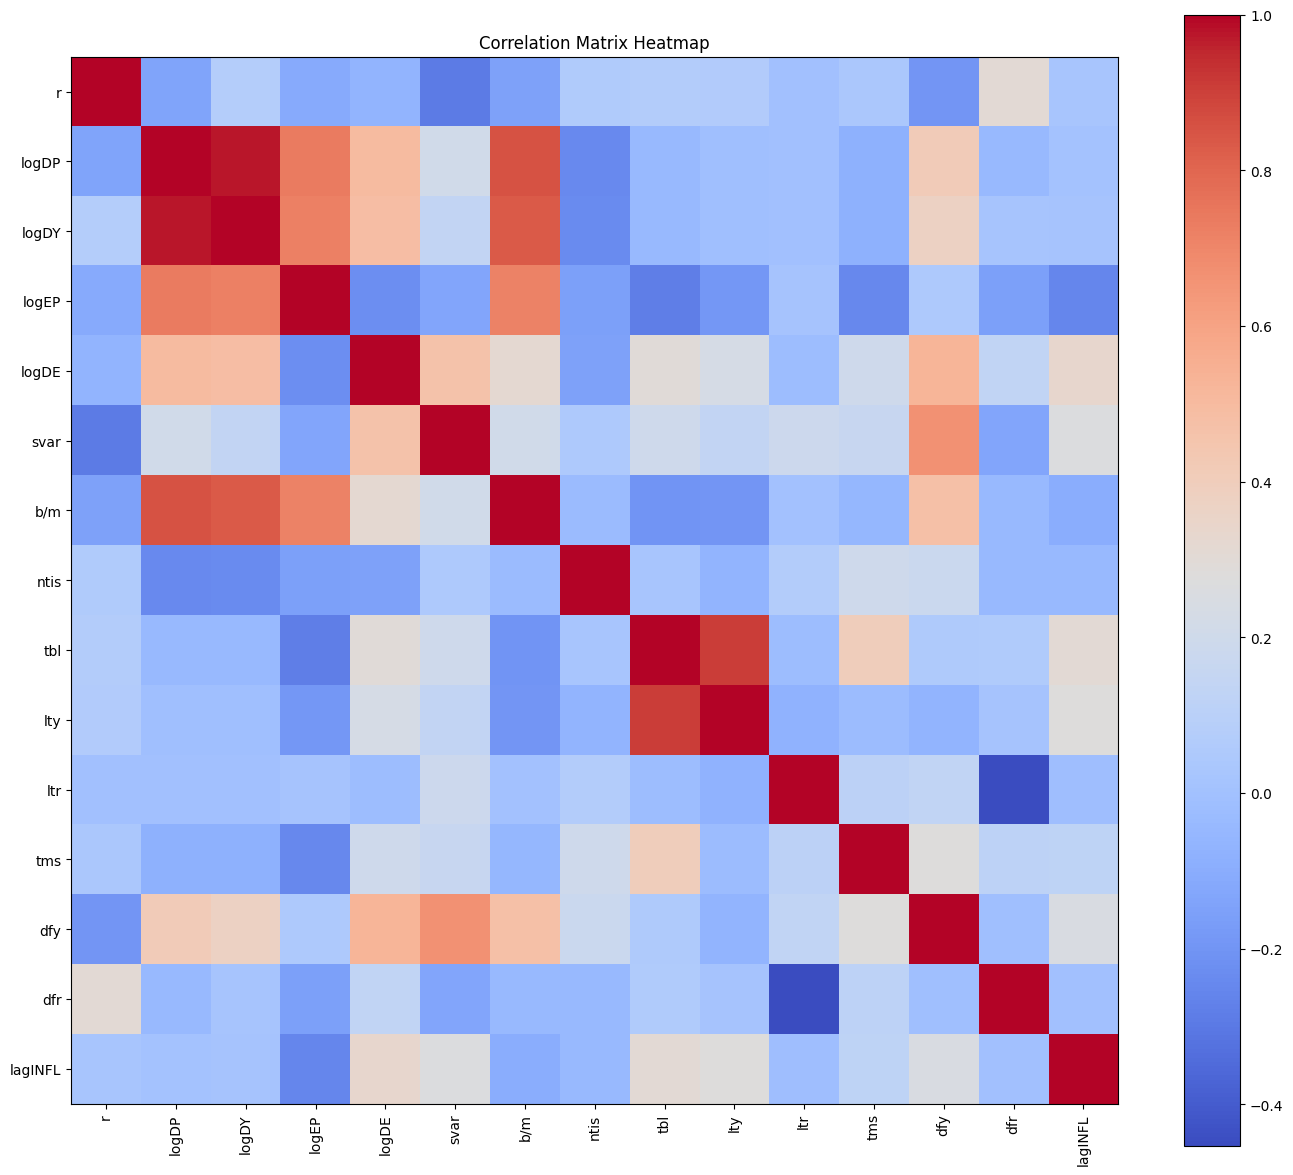

In [55]:
# Calculate the correlation matrix
correlation_matrix = dfPredictors[dfPredictors.columns[1:]].corr() # Exclude 'yyyyq' from correlation calculation

# Display the correlation matrix
print("Correlation Matrix:")
correlation_matrix

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(14, 12))
im = plt.imshow(correlation_matrix, cmap='coolwarm')
plt.colorbar(im)
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
plt.title('Correlation Matrix Heatmap')
plt.tight_layout()
plt.show()

## Question 1 simple regression for each predictor

In [ ]:

def simple_regression(data, dependant_var, independent_var):
    """Performs a simple linear regression of dependant_var on independent_var.
    Args:
        pdData: The dataframe containing the data.
        strDependant_var : The name of the dependent variable column.
        strIndependent_var : The name of the independent variable column.

    Returns:
        dict: A dictionary containing regression results, coefficients, adjusted R², p-values, and robust standard errors in a list
    """
    X = data[independent_var][:-1].reset_index(drop=True) 
    y = data[dependant_var][1:].reset_index(drop=True)


    X = sm.add_constant(X)  # Adds a constant term to the predictor
    model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags': 6})  # Using robust standard errors


    t_stat = model.tvalues.iloc[1]  # t-statistic for the independent variable
    two_sided_p = model.pvalues[independent_var]

    if t_stat > 0:
        one_sided_p = two_sided_p / 2
    else:
        one_sided_p = 1 - (two_sided_p / 2)

    # Extract relevant information
    results = {
        "predicted_name": f"{independent_var}", # get the string name of the predictor
        "beta": model.params.iloc[1],
        "HAC t_tests": t_stat,
        "one_sided_pvalue": one_sided_p,  # One-tailed p-value
        "Adj. R²": model.rsquared_adj,
    }

    return results

all_results = []

for col in dfPredictors.columns[2:]:
    result = simple_regression(dfPredictors, 'r', col)
    all_results.append(result)

indiv_regression_results = pd.DataFrame(all_results)
indiv_regression_results



,predicted_name,beta,HAC t_tests,one_sided_pvalue,Adj. R²
0,logDP,0.016918,1.200930,0.114889,0.003390
1,logDY,0.015166,1.178830,0.119233,0.002087
2,logEP,0.022743,1.599786,0.054823,0.005995
3,logDE,-0.002320,-0.095640,0.538097,-0.002563
4,svar,0.135355,0.257452,0.398415,-0.002248
5,b/m,0.048654,1.766798,0.038631,0.013268
6,ntis,0.525127,1.829235,0.033682,0.013928
7,tbl,0.232338,1.586006,0.056369,0.002054
8,lty,0.204795,1.316342,0.094030,0.000432
9,ltr,0.172413,1.651612,0.049307,0.003737


## Question 2

In [ ]:
# Splits of the data
total_obs = len(dfPredictors)
m = 80 # Initial in-sample period (20 years * 4 quarters)
p = 40
q = total_obs - m - p  # Out-of-sample period

predictor_variables = dfPredictors.columns[2:]

print(f"Total Observations (T): {total_obs}")
print(f"In-sample size (m): {m}")
print(f"Out-of-sample size (p): {p}")

# --- Get the list of predictors ---
predictor_variables = dfPredictors.columns[2:]

# --- Initialize lists to store final results ---
oos_results_list = []

# --- 2. Calculate Benchmark MSPE ---
benchmark_forecasts = []
for t in range(m+p, total_obs - 1):
    # The benchmark forecast for t+1 is the mean of returns up to t
    historical_mean = dfPredictors['r'].iloc[:-1].mean()
    benchmark_forecasts.append(historical_mean)

# Get the actual returns for the OOS period
actual_returns_oos = dfPredictors['r'].iloc[m+p:total_obs-1].values
mspe_benchmark = np.mean((actual_returns_oos - np.array(benchmark_forecasts))**2)


# --- 3. Outer loop through each predictor ---
for predictor in predictor_variables:
    
    # Initialize list to store forecasts for this specific predictor
    model_forecasts = []
    
    # --- 4. Inner loop for the expanding window ---
    for t in range(m+p, total_obs - 1):
        # The estimation window expands from the start (0) up to the current period (t)
        # The data used for estimation has t+1 observations (e.g., from index 0 to t)
        df_window = dfPredictors.iloc[0:t+1]
        
        # --- Run the simple regression for the current window ---
        y = df_window['r']
        X = df_window[predictor].shift(1) # Lag the predictor
        X = sm.add_constant(X)
        
        # Note: For forecasting, we typically use standard OLS, as the focus is
        # on the coefficient estimates, not their standard errors.
        model = sm.OLS(y, X, missing='drop').fit()
        
        # --- Make a one-step-ahead forecast for period t+1 ---
        # The predictor value at time t (the last row of the window) forecasts the return at t+1
        last_predictor_value = df_window[predictor].iloc[-1]
        forecast = model.params['const'] + model.params[predictor] * last_predictor_value
        
        model_forecasts.append(forecast)

    # --- 5. Calculate MSPE and R2_OOS for this predictor ---
    mspe_model = np.mean((actual_returns_oos - np.array(model_forecasts))**2)
    
    # The out-of-sample R-squared
    r2_oos = 1 - (mspe_model / mspe_benchmark)
    
    # Store the results
    oos_results_list.append({
        'Predictor': predictor,
        'R2_OOS': r2_oos
    })

# --- 6. Create and display the final summary table ---
oos_results_df = pd.DataFrame(oos_results_list)

print("\n--- Question 2: Out-of-Sample R-squared Results ---")
# Sort by R2_OOS to easily see the best and worst performing models
print(oos_results_df.sort_values('R2_OOS', ascending=False).to_string(index=False))

Total Observations (T): 385
In-sample size (m): 80
Out-of-sample size (p): 40

--- Question 2: Out-of-Sample R-squared Results ---
Predictor    R2_OOS
      tbl  0.035950
      lty  0.021890
      tms  0.012792
    logDY  0.010171
  lagINFL  0.009649
      dfy  0.001679
     svar -0.001272
      ltr -0.012505
    logDE -0.013008
     ntis -0.021200
      dfr -0.038493
    logDP -0.077692
    logEP -0.129437
      b/m -0.167883


## Question 3

## Question 4


## Question 5